# Defending against backdoor poisoning attacks using STRIP

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
warnings.filterwarnings('ignore')
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d

from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd, add_single_bd, insert_image
from art.utils import load_mnist, preprocess
from art.defences.detector.poison import ActivationDefence
from art.defences.transformer.poisoning import STRIP

# disable TensorFlow eager execution
import tensorflow as tf
if tf.executing_eagerly():
    tf.compat.v1.disable_eager_execution()

In [3]:
if(len(tf.config.list_physical_devices('GPU'))<1):
  print("GPU acceleration is recommended for this notebook")

### The classification problem: Automatically detect numbers written in a check
![image.png](../utils/data/images/classification_mnist.png)

In [4]:
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)

# Random Selection:
n_train = np.shape(x_raw)[0]
num_selection = 7500
random_selection_indices = np.random.choice(n_train, num_selection)
x_raw = x_raw[random_selection_indices]
y_raw = y_raw[random_selection_indices]

BACKDOOR_TYPE = "pattern" # one of ['pattern', 'pixel', 'image']

### Adversary's goal: make some easy money

In [1]:
from IPython.display import HTML
HTML('<img src="../utils/data/images/zero_to_one.png" width=400>')

In [6]:
max_val = np.max(x_raw)
def add_modification(x):
  if BACKDOOR_TYPE == 'pattern':
      return add_pattern_bd(x, pixel_value=max_val)
  elif BACKDOOR_TYPE == 'pixel':
      return add_single_bd(x, pixel_value=max_val)
  elif BACKDOOR_TYPE == 'image':
      return insert_image(x, backdoor_path='../utils/data/backdoors/alert.png', size=(10,10))
  else:
      raise("Unknown backdoor type")

In [7]:
def poison_dataset(x_clean, y_clean, percent_poison, poison_func):
    x_poison = np.copy(x_clean)
    y_poison = np.copy(y_clean)
    is_poison = np.zeros(np.shape(y_poison))

    sources = np.arange(10)
    targets = np.array([1] * 10)
    for i, (src, tgt) in enumerate(zip(sources, targets)):
        n_points_in_tgt = np.size(np.where(y_clean == tgt))
        num_poison = round((percent_poison * n_points_in_tgt) / (1 - percent_poison))
        src_imgs = x_clean[y_clean == src]

        n_points_in_src = np.shape(src_imgs)[0]
        indices_to_be_poisoned = np.random.choice(n_points_in_src, num_poison)

        imgs_to_be_poisoned = np.copy(src_imgs[indices_to_be_poisoned])
        backdoor_attack = PoisoningAttackBackdoor(poison_func)
        imgs_to_be_poisoned, poison_labels = backdoor_attack.poison(imgs_to_be_poisoned, y=np.ones(num_poison) * tgt)
        x_poison = np.append(x_poison, imgs_to_be_poisoned, axis=0)
        y_poison = np.append(y_poison, poison_labels, axis=0)
        is_poison = np.append(is_poison, np.ones(num_poison))

    is_poison = is_poison != 0

    return is_poison, x_poison, y_poison

In [8]:
# Poison training data
percent_poison = .33
(is_poison_train, x_poisoned_raw, y_poisoned_raw) = poison_dataset(x_raw, y_raw, percent_poison, add_modification)
x_train, y_train = preprocess(x_poisoned_raw, y_poisoned_raw)
# Add channel axis:
x_train = np.expand_dims(x_train, axis=3)

# Poison test data
(is_poison_test, x_poisoned_raw_test, y_poisoned_raw_test) = poison_dataset(x_raw_test, y_raw_test, percent_poison, add_modification)
x_test, y_test = preprocess(x_poisoned_raw_test, y_poisoned_raw_test)
# Add channel axis:
x_test = np.expand_dims(x_test, axis=3)

# Shuffle training data
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]


# Victim bank trains a neural network

In [9]:
# Create Keras convolutional neural network - basic architecture from Keras examples
# Source here: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:]))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
classifier = KerasClassifier(model=model, clip_values=(min_, max_))
classifier.fit(x_train, y_train, nb_epochs=3, batch_size=128)

Train on 11750 samples
Epoch 1/3
11750/11750 [==============================] - 9s 777us/sample - loss: 0.6840 - accuracy: 0.7826
Epoch 2/3
11750/11750 [==============================] - 1s 74us/sample - loss: 0.1945 - accuracy: 0.9420
Epoch 3/3
11750/11750 [==============================] - 1s 76us/sample - loss: 0.1280 - accuracy: 0.9631


# The victim bank evaluates the model

### Evaluation on clean test samples


Clean test set accuracy: 97.02%


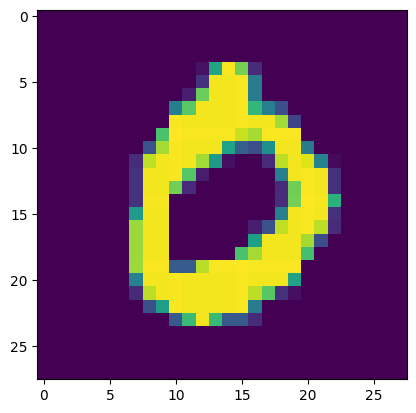

Prediction: 0


In [11]:
clean_x_test = x_test[is_poison_test == 0]
clean_y_test = y_test[is_poison_test == 0]

clean_preds = np.argmax(classifier.predict(clean_x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(clean_y_test, axis=1))
clean_total = clean_y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy: %.2f%%" % (clean_acc * 100))

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(clean_y_test,1) == c)[0][i] # index of the image in clean arrays

plt.imshow(clean_x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))

### But the adversary has other plans...

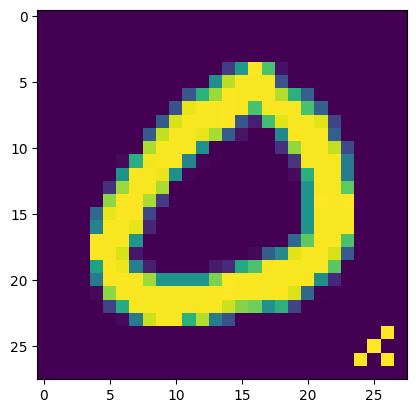

Prediction: 1

 Effectiveness of poison: 100.00%


In [12]:
poison_x_test = x_test[is_poison_test]
poison_y_test = y_test[is_poison_test]

poison_preds = np.argmax(classifier.predict(poison_x_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(poison_y_test, axis=1))
poison_total = poison_y_test.shape[0]

# Display image, label, and prediction for a poisoned image to see the backdoor working

c = 1 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(poison_y_test,1) == c)[0][i] # index of the image in poison arrays

plt.imshow(poison_x_test[c_idx].squeeze())
plt.show()
poison_label = c
print("Prediction: " + str(poison_preds[c_idx]))

poison_acc = poison_correct / poison_total
print("\n Effectiveness of poison: %.2f%%" % (poison_acc * 100))

### Evaluate accuracy on entire test set

In [13]:
total_correct = clean_correct + poison_correct
total = clean_total + poison_total

total_acc = total_correct / total
print("\n Overall test set accuracy (i.e. effectiveness of poison): %.2f%%" % (total_acc * 100))


 Overall test set accuracy (i.e. effectiveness of poison): 98.09%


# Filter Poison Using STRIP

In [14]:
strip = STRIP(classifier)
defence = strip()
defence.mitigate(clean_x_test[:100])

  0%|          | 0/100 [00:00<?, ?it/s]

In [15]:
poison_preds = defence.predict(poison_x_test)
clean_preds = defence.predict(clean_x_test[100:])

num_abstained_poison = np.sum(np.all(poison_preds == np.zeros(10),axis=1))
num_abstained_clean = np.sum(np.all(clean_preds == np.zeros(10),axis=1))
num_poison = len(poison_preds)
num_clean = len(clean_preds)

print(f"Abstained {num_abstained_poison}/{num_poison} poison samples ({round(num_abstained_poison / float(num_poison)* 100, 2)}% TP rate)")
print(f"Abstained {num_abstained_clean}/{num_clean} clean samples ({round(num_abstained_clean / float(num_clean) * 100, 2)}% FP rate)")

Abstained 1917/5590 poison samples (34.29% TP rate)
Abstained 163/9900 clean samples (1.65% FP rate)
